# Sprint　深層学習スクラッチ　ディープニューラルネットワーク  

＜目的＞  
- スクラッチを通してニューラルネットワークの発展的内容を理解する

前回は3層のニューラルネットワークを作成しましたが、今回はこれを任意の層数に拡張しやすいものに書き換えていきます。その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていきます。  
このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指します。  
名前は新しくScratchDeepNeuralNetrowkClassifierクラスとしてください。

＜層などのクラス化＞  
クラスにまとめて行くことで、構成を変更しやすい実装にしていきます。


**手を加える箇所**  
- 層の数
- 層の種類（今後畳み込み層など他のタイプの層が登場する）
- 活性化関数の種類
- 重みやバイアスの初期化方法
- 最適化手法

そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成します。

### 【問題1】全結合層のクラス化  
全結合層のクラス化を行なってください。  
以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。  
なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。  
また、引数として自身のインスタンス``self``を渡すこともできます。これを利用して``self.optimizer.update(self)``という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。  
初期化方法と最適化手法のクラスについては後述します。

In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import copy
from sklearn import metrics 
from scipy.special import expit

Using TensorFlow backend.


In [2]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, batch_size, initializer, activator, optimizer):
        # 初期化
        # initializerのメソッドを使い、Bias成分を付け加えてself.Wを初期化する
        self.W = initializer.W(n_nodes1 + 1, n_nodes2)
        # E(dW)計算のため、バッチサイズを受け取る
        self.batch_size = batch_size
        # 活性化関数、最適化手法も受け取る
        self.activator = activator
        self.optimizer = optimizer
    
    # 順伝播
    def forward(self, X, y):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = np.insert(X, 0, 1, axis=1)
        self.A = self.X @ self.W
        # 活性化関数を通し、Zを出力する形にする
        return self.activator.activate(self.A, y)
    
    # 逆伝播
    def backward(self, y):
        """
        バックワード
        Parameters
        ----------
        y : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 活性化関数のヤコビアンを通し、dAを得る
        dA = self.activator.jacobian(y)
        # 層の入力とバッチサイズから、E(dW)を得る
        self.dW = ((self.X).T @ dA) / self.batch_size
        # WのBias成分である1行目を落とし、次に渡すdZを得る
        W = np.delete(self.W, 0, 0)
        dZ = dA @ W.T
        # 上記を作成後、受け取った最適化手法でWを更新
        self.optimizer.update(self)
        return dZ

### 【問題2】初期化のクラス化  
初期化を行うコードをクラス化してください。  
前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。以下の雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。  
これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

In [3]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
          初期化された重み
        """
        # Bias成分はFCクラスのコンストラクタで呼び出す際に付け加える
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

### 【問題3】最適化手法のクラス化  
最適化手法のクラス化を行なってください。  
最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself.optimizer.update(self)のように更新できるようにします。以下の雛形に必要なコードを書き加えていってください。  
これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [4]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    
    def update(self, connect):
        """
        ある結合層の重みの更新
        Parameters
        ----------
        connect : object
          更新前の層のインスタンス
        """
        # Bias成分を含めたWを更新する
        connect.W -= self.lr*connect.dW
        return self

### 【問題4】活性化関数のクラス化  
活性化関数のクラス化を行なってください。  
ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。  

＜発展的要素＞  
活性化関数や重みの初期値、最適化手法に関してこれまで見てきた以外のものを実装していきます。

In [5]:
# シグモイド関数
class Sigmoid:
    # 順伝播時の関数メソッド（softmaxに合わせ、yも引数にとるが使用しない）
    def activate(self, A, y):
        self.Z = 1. / (1. + np.exp(-A))
        # 逆伝播時に使用する変数を保持
        return self.Z
    
    # 逆伝播時のヤコビアン計算メソッド
    def jacobian(self, dZ):
        dA = dZ*(1. - self.Z)*self.Z
        return dA

In [6]:
# ハイパボリックタンジェント関数
class Tanh:
    # 順伝播時の関数メソッド（softmaxに合わせ、yも引数にとるが使用しない）
    def activate(self, A, y):
        # 逆伝播時に使用する変数を保持
        self.Z = np.tanh(A)
        return self.Z
    
    # 逆伝播時のヤコビアン計算メソッド
    def jacobian(self, dZ):
        dA = dZ*(1. - self.Z**2)
        return dA

In [7]:
# ソフトマックス関数
class Softmax:
    # 順伝播時の関数メソッド
    def activate(self, A, y):
        exp_sigma = np.sum(np.exp(A), axis=1)[:, np.newaxis]
        sigma_matrix = np.tile(exp_sigma, (1, A.shape[1]))
        # 逆伝播時に使用する変数を保持
        self.Z = np.exp(A)/sigma_matrix
        # 学習時はエントロピーを返す
        if y is not None:
            entropy = np.sum(np.log(self.Z)*y)/A.shape[0]*(-1)
            output = entropy
        # 推定時は予測行列を返す
        else:
            output = self.Z
        return output
    
    # 逆伝播時のヤコビアン計算メソッド
    def jacobian(self, y):
        dA = self.Z - y
        return dA

### 【問題5】ReLUクラスの作成  
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。

ReLUは以下の数式です。

$$
% <![CDATA[
f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$$

$x$ : ある特徴量。スカラー

実装上はnp.maximumを使い配列に対してまとめて計算が可能です。  
一方、バックプロパゲーションのための $x$ に関する $f(x)$ の微分は以下のようになります。

$$
% <![CDATA[
\frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$$

数学的には微分可能ではないですが、 $x=0$ のとき $0$ とすることで対応しています。  
フォワード時の $x$ の正負により、勾配を逆伝播するかどうかが決まるということになります。

In [36]:
# Relu関数
class ReLU:
    # 順伝播時の関数メソッド（softmaxに合わせ、yも引数にとるが使用しない）
    def activate(self, A, y):
        # 逆伝播時に使用する変数を保持
        self.Z = np.maximum(A, 0)
        return self.Z
    
    # 逆伝播時のヤコビアン計算メソッド
    def jacobian(self, dZ):
        dA = dZ*(np.where(self.Z==0, 0, 1))
        return dA

### 【問題6】重みの初期値  
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、どのような値にすると良いかが知られています。シグモイド関数やハイパボリックタンジェント関数のときは **Xavierの初期値** （またはGlorotの初期値）、ReLUのときは **Heの初期値** が使われます。  
XavierInitializerクラスと、HeInitializerクラスを作成してください。

＜Xavierの初期値＞  
Xavierの初期値における標準偏差 $\sigma$ は次の式で求められます。

$$
\sigma = \frac{1}{\sqrt{n}}
$$

$n$ : 前の層のノード数


＜Heの初期値＞  
Heの初期値における標準偏差 $\sigma$ は次の式で求められます。

$$
\sigma = \sqrt{\frac{2}{n}}
$$

$n$ : 前の層のノード数

In [9]:
# Xavierの初期値
class XavierInitializer:
    """
    Xavier法による初期化
    Parameters
    ----------
    n_nodes1 : float
      前の層のノード数
    """
    def __init__(self, n_nodes1):
        self.sigma = 1 / np.sqrt(n_nodes1)
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :次の形のndarray, shape (n_nodes1, n_nodes2)
          初期化された重み
        """
        # Bias成分はFCクラスのコンストラクタで呼び出す際に付け加える
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

In [10]:
# Heの初期値
class HeInitializer:
    """
    He法による初期化
    Parameters
    ----------
    n_nodes1 : float
      前の層のノード数
    """
    def __init__(self, n_nodes1):
        self.sigma = np.sqrt(2 / n_nodes1)
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :次の形のndarray, shape (n_nodes1, n_nodes2)
          初期化された重み
        """
        # Bias成分はFCクラスのコンストラクタで呼び出す際に付け加える
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

### 【問題7】最適化手法  
学習率は学習過程で変化させていく方法が一般的です。基本的な手法である AdaGrad のクラスを作成してください。  
まず、これまで使ってきたSGDを確認します。

$$
W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) \\  
B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})
$$

$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）  
$\frac{\partial L}{\partial W_i}$ : $W_i$ に関する損失 $L$ の勾配  
$\frac{\partial L}{\partial B_i}$ : $B_i$ に関する損失 $L$ の勾配  
$E()$ : ミニバッチ方向にベクトルの平均を計算  

続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。  
更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和 $H$ を保存しておき、その分だけ学習率を小さくします。  
学習率は重み一つひとつに対して異なることになります。  

$$
H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\  
W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) \\
$$

$H_i$ : i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）  
$H_i^{\prime}$ : 更新した $H_i$

In [11]:
class AdaGrad:
    """
    学習係数減衰勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.H = None
    
    def update(self, connect):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
    　　connect : object
          更新前の層のインスタンス
        """
        # Hの初期化
        if self.H is None:
            self.H = np.zeros_like(connect.dW)
        self.H += connect.dW**2
        # Bias成分を含めたWを更新する
        # zero division回避のため小さな値を加える
        connect.W -= self.lr/(np.sqrt(self.H) + 1e-7)*connect.dW
        return self

### 【おまけ】最適化手法  
AdaGradに加え、Momentumクラスも実装してみる。  
Momentumでは、以下の式で$W$を更新する。

$$
v_i^{\prime} = {\eta}v_i - \alpha E(\frac{\partial L}{\partial W_i}) \\  
W_i^{\prime} = W_i + v_i^{\prime} \\
$$

Momentumは物体が勾配方向に受け続ける力を再現しており、動きとしては「ボールがお椀を転がる動き」と表現される。  
今回は$\eta$を0.8で固定する。

In [12]:
class Momentum:
    """
    学習係数減衰勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.v = None
    
    def update(self, connect):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        connect : object
          更新前の層のインスタンス
        """
        # vの初期化
        if self.v is None:
            self.v = np.zeros_like(connect.dW)
        self.v = 0.8*self.v - self.lr*connect.dW
        # Bias成分を含めたWを更新する
        connect.W += self.v
        return self

### 【問題8】クラスの完成  
任意の構成で学習と推定が行えるScratchDeepNeuralNetrowkClassifierクラスを完成させてください。

In [13]:
# mini Batch取得クラス
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [35]:
# DeepNeuralNetクラス
class ScratchDeepNeuralNetrowkClassifier():
    """
    任意に構成できるニューラルネットワーク分類器

    Parameters
    ----------
    n_layers : int
      入出力層も含めた層の総数
    n_nodes : list
      隠れ層のノード数を格納したリスト
    sigma : float
      Gauss分布初期化時に使用する標準偏差
    initializer : str
      初期化手法を指定するストリングス    
    activator : str
      活性化関数を指定するストリングス    
    optimizer : str
    　最適化手法を指定するストリングス
    lr : float
      学習率
    batch_size : int
    　学習時のミニバッチサイズ
    epoch : int
    　学習のエポック数
    interval : int
    　クロスエントロピー記録のiterationに対する間隔
    verbose : bool
    　クロスエントロピー出力の有無

    Attributes
    ----------
    self.connections : list
      全結合層のオブジェクトリスト
    self.cross_entropys : list
      訓練データ学習時のクロスエントロピー格納リスト
    self.cross_entropys_val : list
    　検証データのクロスエントロピー格納リスト
    """
    def __init__(self, n_layers, n_nodes, initializer, sigma, activator, optimizer, lr, batch_size, epoch, interval, verbose):
        self.n_layers = n_layers
        self.n_nodes = n_nodes
        self.sigma = sigma
        self.initializer = initializer
        self.activator = activator
        self.optimizer = optimizer
        self.lr = lr
        self.batch_size = batch_size
        self.epoch = epoch
        self.interval = interval
        self.verbose = verbose
        # 以下はAttributes
        self.connections = []
        self.cross_entropys = []
        self.cross_entropys_val = []
        
    def fit(self, X, y, X_val=None, y_val=None):
        # 入出力層も含めた全層のノード数リスト生成
        n_features = X.shape[1]
        n_outputs = len(np.unique(y))
        self.n_nodes.insert(0, n_features)
        self.n_nodes.append(n_outputs)
        
        # 指定の手法でインスタンスを初期化
        # Initializer
        if self.initializer=='Gauss':
            self.initializer = SimpleInitializer(self.sigma)
        elif self.initializer=='Xavier':
            self.initializer = XavierInitializer(n_features)
        elif self.initializer=='He':
            self.initializer = HeInitializer(n_features)
        # Activator
        if self.activator=='sigmoid':
            self.activator = Sigmoid()
        elif self.activator=='tanh':
            self.activator = Tanh()
        elif self.activator=='ReLU':
            self.activator = ReLU()
        # Optimizer
        if self.optimizer=='SGD':
            self.optimizer = SGD(self.lr)
        elif self.optimizer=='AdaGrad':
            self.optimizer = AdaGrad(self.lr)
        elif self.optimizer=='Momentum':
            self.optimizer = Momentum(self.lr)
        
        # 上記のリストをもとに、結合層のオブジェクトリスト作成
        for c in range(1, self.n_layers):
            connect = FC(n_nodes1=self.n_nodes[c-1], 
                         n_nodes2=self.n_nodes[c], 
                         batch_size=self.batch_size,
                         initializer=copy.deepcopy(self.initializer), 
                         activator=copy.deepcopy(self.activator), 
                         optimizer=copy.deepcopy(self.optimizer))
            self.connections.append(connect)
        # 出力層の活性化関数のみ、Softmax関数へ更新
        self.connections[-1].activator = Softmax()
        
        # 訓練/検証データの正解ラベルをone-hotへ
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_one_hot = enc.fit_transform(y[:, np.newaxis])
        if y_val is not None:
            y_val_one_hot = enc.fit_transform(y_val[:, np.newaxis])
        
        # epochのループ
        for e in range(self.epoch):
            # ミニバッチのインスタンス生成
            mini_batch_train = GetMiniBatch(X, y_one_hot, self.batch_size)
            # エントロピー記録時に使うループ数を初期化
            n_iter = 0
            # バッチのループ
            for mini_X_train, mini_y_train in mini_batch_train:
                
                # 検証データサイズが大きいため、指定したインターバル時のみforward
                if X_val is not None and n_iter % self.interval == 0:
                    # forward用の変数作成
                    Z_val = copy.deepcopy(X_val)
                    # 層のループ
                    for c in range(1, self.n_layers):
                        # 指定した結合層で、変数を更新していく
                        connect = self.connections[c-1]
                        Z_val = connect.forward(Z_val, y_val_one_hot)
                    # エントロピー格納
                    self.cross_entropys_val.append(Z_val)
                
                # 訓練データの変数作成
                y = mini_y_train
                Z = copy.deepcopy(mini_X_train)
                
                # 検証データと同様のforward
                for c in range(1, self.n_layers):
                    connect = self.connections[c-1]
                    Z = connect.forward(Z, y)
                # 指定したインターバル時にエントロピー格納
                if n_iter % self.interval == 0:
                    self.cross_entropys.append(Z)
                
                # 訓練データのforward直後に、変数を作成しbackwardを行う
                dZ = copy.deepcopy(y)
                for c in range(1, self.n_layers):
                    # 指定した結合層で、変数を更新していく
                    connect = self.connections[self.n_layers-1-c]
                    dZ = connect.backward(dZ)
                
                # インターバル用のループ数を1増やす
                n_iter += 1

        # verboseの場合、Cross Etropyのリストを出力する
        if self.verbose:
            print('Cross Entropy (train) :\n', self.cross_entropys)
            if X_val is not None and y_val is not None:
                print('Cross Entropy (Validation) :\n', self.cross_entropys_val)
        
        return self

    
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        # y=Noneとしてforward
        for c in range(1, self.n_layers):
            connect = self.connections[c-1]
            X = connect.forward(X, y=None)
        # 予測行列が帰るので、ラベルへ変換し出力
        pred_matrix = X
        return np.argmax(pred_matrix, axis=1)

In [15]:
# データセットのロード、確認
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# 分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [16]:
snn = ScratchDeepNeuralNetrowkClassifier(n_layers=4, 
                                         n_nodes=[40, 20], 
                                         initializer='Gauss', 
                                         sigma=0.05, 
                                         activator='tanh', 
                                         optimizer='SGD', 
                                         lr=0.01, 
                                         batch_size=20, 
                                         epoch=10, 
                                         interval=500,
                                         verbose=True)
snn.fit(X_train, y_train, X_val, y_val)

Cross Entropy (train) :
 [2.292686865396708, 2.2199279746112937, 1.7226451842896757, 1.3016224056626098, 0.7335519336325846, 0.8618067862361933, 0.4131183532433182, 0.6090746529682608, 0.40207708638246176, 0.5255078266240949, 0.650754291692804, 0.309044967421246, 0.42478048478200164, 0.28036257282397764, 0.4841309962456748, 0.5827182094873755, 0.30909680350847923, 0.3251498411918823, 0.2105427098380515, 0.4111045049534354, 0.5269244081752564, 0.30869199826009563, 0.26434110841341846, 0.16693291701305185, 0.3560431365858967, 0.4740387239993291, 0.3081799602944589, 0.21739545479603145, 0.13847813567281203, 0.3229512772908164, 0.42822940602688864, 0.30897450442890595, 0.1757846592719336, 0.1142895608231929, 0.3007608895827921, 0.3895635758032568, 0.30834677442701863, 0.14045245707010492, 0.09189066416768857, 0.28361289693818764, 0.3551148440210682, 0.30458483962893546, 0.11335409933714138, 0.07203897856067817, 0.2690090819750386, 0.32296685761241817, 0.297300799431823, 0.09381952520755546

In [17]:
# Accuracy算出
y_pred = snn.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

Accuracy : 0.951


In [18]:
# 学習曲線描画関数
def learning_curve(iteration, interval, loss, loss_val):
    n_record = iteration//interval
    plt.plot(np.arange(n_record), loss, label='train_loss')
    plt.plot(np.arange(n_record), loss_val, label='val_loss')
    plt.title('model loss')
    plt.xlabel('iteration / interval')
    plt.ylabel('cross entropy')
    plt.legend()
    plt.show()

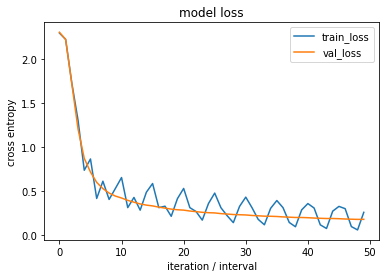

In [19]:
# 上記の学習で描画
learning_curve(25000, 500, snn.cross_entropys, snn.cross_entropys_val)

- 評価指標や学習曲線を見るに、挙動は適切のようだ
- 前回の課題では$dL/dW$にminiBatchの合計を用いていたが、今回は平均となったためepoch数を増やさないと学習が進まない

### 【問題9】学習と推定  
層の数や活性化関数を変えたいくつかのネットワークを作成してください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください。 

### ＜方針＞  
　以下の観点で比較を行う
1. Initializer
2. Activator
3. Optimizer
4. Xavier, $tanh$ vs He, $ReLU$
5. Layers
6. Nodes

　比較対象以外の条件は同一とする

### 1. Initializer
活性化は$tanh$、最適化はSGDで統一

== Scratch Deep Neural Netrowk ==
< Initializer : Gauss(σ=0.01), Activator : Tanh, Optimizer : SGD >
< number of hiddenlayers : 2 ( nodes : 40,20) >

< Lerning Curve >


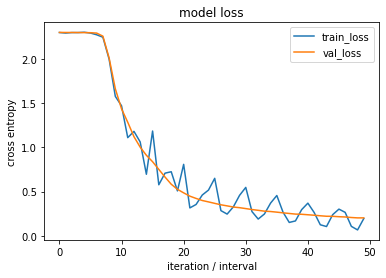

< Metrics >
Accuracy : 0.944


In [20]:
# 初期化 : Gauss(σ=0.01), 活性化関数 : Tanh, 最適化 : SGD
print('== Scratch Deep Neural Netrowk ==')
print('< Initializer : Gauss(σ=0.01), Activator : Tanh, Optimizer : SGD >')
print('< number of hiddenlayers : 2 ( nodes : 40,20) >\n')
snn_g = ScratchDeepNeuralNetrowkClassifier(n_layers=4, 
                                           n_nodes=[40, 20], 
                                           initializer='Gauss', 
                                           sigma=0.01, 
                                           activator='tanh', 
                                           optimizer='SGD', 
                                           lr=0.01, 
                                           batch_size=20, 
                                           epoch=10, 
                                           interval=500,
                                           verbose=False)
snn_g.fit(X_train, y_train, X_val, y_val)
# 学習曲線描画
print('< Lerning Curve >')
learning_curve(25000, 500, snn_g.cross_entropys, snn_g.cross_entropys_val)

# Accuracy算出
print('< Metrics >')
y_pred = snn_g.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

== Scratch Deep Neural Netrowk ==
< Initializer : Xavier, Activator : Tanh, Optimizer : SGD >
< number of hiddenlayers : 2 ( nodes : 40,20) >

< Lerning Curve >


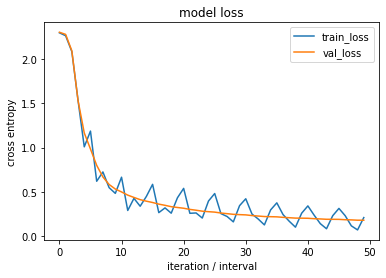

< Metrics >
Accuracy : 0.949


In [21]:
# 初期化 : Xavier, 活性化関数 : Tanh, 最適化 : SGD
print('== Scratch Deep Neural Netrowk ==')
print('< Initializer : Xavier, Activator : Tanh, Optimizer : SGD >')
print('< number of hiddenlayers : 2 ( nodes : 40,20) >\n')
snn_x = ScratchDeepNeuralNetrowkClassifier(n_layers=4, 
                                           n_nodes=[40, 20], 
                                           initializer='Xavier', 
                                           sigma=None, 
                                           activator='tanh', 
                                           optimizer='SGD', 
                                           lr=0.01, 
                                           batch_size=20, 
                                           epoch=10, 
                                           interval=500,
                                           verbose=False)
snn_x.fit(X_train, y_train, X_val, y_val)
# 学習曲線描画
print('< Lerning Curve >')
learning_curve(25000, 500, snn_x.cross_entropys, snn_x.cross_entropys_val)

# Accuracy算出
print('< Metrics >')
y_pred = snn_x.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

== Scratch Deep Neural Netrowk ==
< Initializer : He, Activator : Tanh, Optimizer : SGD >
< number of hiddenlayers : 2 ( nodes : 40,20) >

< Lerning Curve >


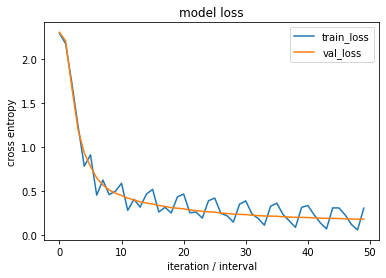

< Metrics >
Accuracy : 0.950


In [22]:
# 初期化 : He, 活性化関数 : Tanh, 最適化 : SGD
print('== Scratch Deep Neural Netrowk ==')
print('< Initializer : He, Activator : Tanh, Optimizer : SGD >')
print('< number of hiddenlayers : 2 ( nodes : 40,20) >\n')
snn_h = ScratchDeepNeuralNetrowkClassifier(n_layers=4, 
                                           n_nodes=[40, 20], 
                                           initializer='He', 
                                           sigma=None, 
                                           activator='tanh', 
                                           optimizer='SGD', 
                                           lr=0.01, 
                                           batch_size=20, 
                                           epoch=10, 
                                           interval=500,
                                           verbose=False)
snn_h.fit(X_train, y_train, X_val, y_val)
# 学習曲線描画
print('< Lerning Curve >')
learning_curve(25000, 500, snn_h.cross_entropys, snn_h.cross_entropys_val)

# Accuracy算出
print('< Metrics >')
y_pred = snn_h.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

== Learning Curves by Initializers ==
< Activator : Tanh, Optimizer : SGD >


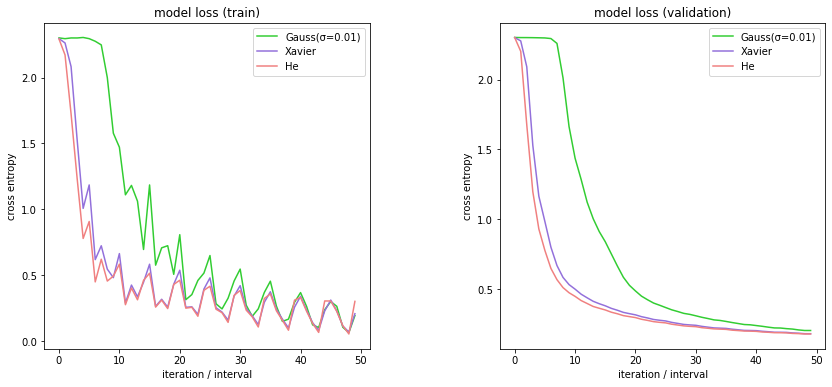

In [23]:
# 手法間でのLearning Curveを比較
print('== Learning Curves by Initializers ==')
print('< Activator : Tanh, Optimizer : SGD >')
plt.figure(figsize=(14,6))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

# 訓練データ
plt.subplot(1,2,1)
plt.plot(np.arange(50), snn_g.cross_entropys, label='Gauss(σ=0.01)', color='limegreen')
plt.plot(np.arange(50), snn_x.cross_entropys, label='Xavier', color='mediumpurple')
plt.plot(np.arange(50), snn_h.cross_entropys, label='He', color='lightcoral')
plt.title('model loss (train)')
plt.xlabel('iteration / interval')
plt.ylabel('cross entropy')
plt.legend()

# 検証データ
plt.subplot(1,2,2)
plt.plot(np.arange(50), snn_g.cross_entropys_val, label='Gauss(σ=0.01)', color='limegreen')
plt.plot(np.arange(50), snn_x.cross_entropys_val, label='Xavier', color='mediumpurple')
plt.plot(np.arange(50), snn_h.cross_entropys_val, label='He', color='lightcoral')
plt.title('model loss (validation)')
plt.xlabel('iteration / interval')
plt.ylabel('cross entropy')
plt.legend()

plt.show()

- $tanh$を使用しているため推奨はXavierだが、Heでもほぼ同じ学習曲線となった。
- $\sigma=1/\sqrt{40}\fallingdotseq0.16$程度であり、Gauss(σ=0.01)より大きいほうが、学習が早く進む結果となった

### 2. Activator  
Gaussでは $sigmoid$ の学習が進まなかったため、初期化はXavierで統一  
最適化はSGDで統一

== Scratch Deep Neural Netrowk ==
< Initializer : Xavier, Activator : Tanh, Optimizer : SGD >
< number of hiddenlayers : 2 ( nodes : 40,20) >

< Lerning Curve >


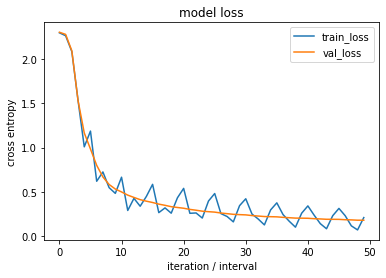

< Metrics >
Accuracy : 0.949


In [24]:
# 初期化 : Xavier, 活性化関数 : Tanh, 最適化 : SGD
print('== Scratch Deep Neural Netrowk ==')
print('< Initializer : Xavier, Activator : Tanh, Optimizer : SGD >')
print('< number of hiddenlayers : 2 ( nodes : 40,20) >\n')
snn_t = ScratchDeepNeuralNetrowkClassifier(n_layers=4, 
                                           n_nodes=[40, 20], 
                                           initializer='Xavier', 
                                           sigma=None, 
                                           activator='tanh', 
                                           optimizer='SGD', 
                                           lr=0.01, 
                                           batch_size=20, 
                                           epoch=10, 
                                           interval=500,
                                           verbose=False)
snn_t.fit(X_train, y_train, X_val, y_val)
# 学習曲線描画
print('< Lerning Curve >')
learning_curve(25000, 500, snn_t.cross_entropys, snn_t.cross_entropys_val)

# Accuracy算出
print('< Metrics >')
y_pred = snn_t.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

== Scratch Deep Neural Netrowk ==
< Initializer : Xavier, Activator : Sigmoid, Optimizer : SGD >
< number of hiddenlayers : 2 ( nodes : 40,20) >

< Lerning Curve >


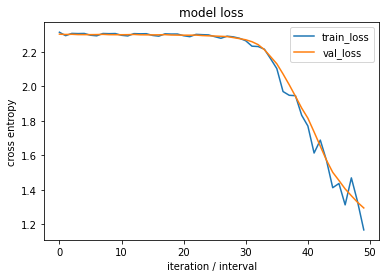

< Metrics >
Accuracy : 0.544


In [25]:
# 初期化 : Xavier, 活性化関数 : Sigmoid, 最適化 : SGD
print('== Scratch Deep Neural Netrowk ==')
print('< Initializer : Xavier, Activator : Sigmoid, Optimizer : SGD >')
print('< number of hiddenlayers : 2 ( nodes : 40,20) >\n')
snn_s = ScratchDeepNeuralNetrowkClassifier(n_layers=4, 
                                           n_nodes=[40, 20], 
                                           initializer='Xavier', 
                                           sigma=None, 
                                           activator='sigmoid', 
                                           optimizer='SGD', 
                                           lr=0.01, 
                                           batch_size=20, 
                                           epoch=10, 
                                           interval=500,
                                           verbose=False)
snn_s.fit(X_train, y_train, X_val, y_val)
# 学習曲線描画
print('< Lerning Curve >')
learning_curve(25000, 500, snn_s.cross_entropys, snn_s.cross_entropys_val)

# Accuracy算出
print('< Metrics >')
y_pred = snn_s.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

== Scratch Deep Neural Netrowk ==
< Initializer : Xavier, Activator : ReLU, Optimizer : SGD >
< number of hiddenlayers : 2 ( nodes : 40,20) >

< Lerning Curve >


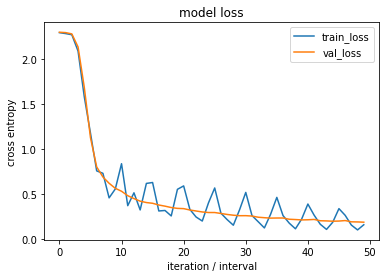

< Metrics >
Accuracy : 0.948


In [26]:
# 初期化 : Xavier, 活性化関数 : ReLU, 最適化 : SGD
print('== Scratch Deep Neural Netrowk ==')
print('< Initializer : Xavier, Activator : ReLU, Optimizer : SGD >')
print('< number of hiddenlayers : 2 ( nodes : 40,20) >\n')
snn_r = ScratchDeepNeuralNetrowkClassifier(n_layers=4, 
                                           n_nodes=[40, 20], 
                                           initializer='Xavier', 
                                           sigma=None, 
                                           activator='ReLU', 
                                           optimizer='SGD', 
                                           lr=0.01, 
                                           batch_size=20, 
                                           epoch=10, 
                                           interval=500,
                                           verbose=False)
snn_r.fit(X_train, y_train, X_val, y_val)
# 学習曲線描画
print('< Lerning Curve >')
learning_curve(25000, 500, snn_r.cross_entropys, snn_r.cross_entropys_val)

# Accuracy算出
print('< Metrics >')
y_pred = snn_r.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

== Learning Curves by Activators ==
< Initializer : Xavier, Optimizer : SGD >


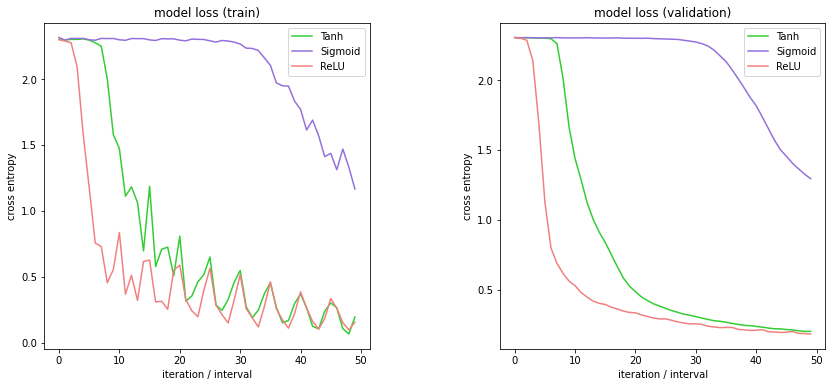

In [27]:
# 手法間でのLearning Curveを比較
print('== Learning Curves by Activators ==')
print('< Initializer : Xavier, Optimizer : SGD >')
plt.figure(figsize=(14,6))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

# 訓練データ
plt.subplot(1,2,1)
plt.plot(np.arange(50), snn_g.cross_entropys, label='Tanh', color='limegreen')
plt.plot(np.arange(50), snn_s.cross_entropys, label='Sigmoid', color='mediumpurple')
plt.plot(np.arange(50), snn_r.cross_entropys, label='ReLU', color='lightcoral')
plt.title('model loss (train)')
plt.xlabel('iteration / interval')
plt.ylabel('cross entropy')
plt.legend()

# 検証データ
plt.subplot(1,2,2)
plt.plot(np.arange(50), snn_g.cross_entropys_val, label='Tanh', color='limegreen')
plt.plot(np.arange(50), snn_s.cross_entropys_val, label='Sigmoid', color='mediumpurple')
plt.plot(np.arange(50), snn_r.cross_entropys_val, label='ReLU', color='lightcoral')
plt.title('model loss (validation)')
plt.xlabel('iteration / interval')
plt.ylabel('cross entropy')
plt.legend()

plt.show()

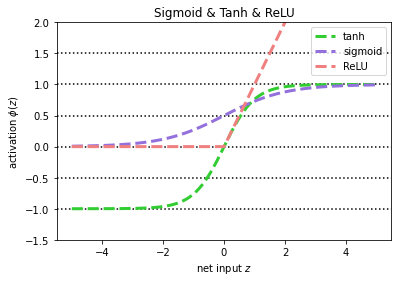

In [28]:
# sigmoid / tanh / ReLUのグラフ
z = np.arange(-5, 5, 0.005)
sigmoid = expit(z)
tanh = np.tanh(z)
ReLU = np.maximum(z, 0)
plt.ylim([-1.5, 2.0])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1.5, color='black', linestyle=':')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh, linewidth=3, linestyle='--', label='tanh', color='limegreen')
plt.plot(z, sigmoid, linewidth=3, linestyle='--', label='sigmoid', color='mediumpurple')
plt.plot(z, ReLU, linewidth=3, linestyle='--', label='ReLU', color='lightcoral')
plt.title('Sigmoid & Tanh & ReLU')
plt.legend()
plt.show()

- 今回の条件では$ReLU$が最も早く学習が進み、次いで$tanh$、大きく遅れて$sigmoid$という結果であった。
- $sigmoid$は勾配の大きさが小さいため学習が進みずらいのは、前回の考察の通り
- $tanh$の勾配 $d\phi(z)/dz$ は原点 0 で最大値 1 をとるが、$ReLU$は $z>0$ の領域で常に $d\phi(z)/dz=1$ となるため勾配消失が起こりにくく、学習が早く進むものと思われる

### 3. Optimizer
初期化はXavier, 活性化は$tanh$で統一

== Scratch Deep Neural Netrowk ==
< Initializer : Xavier, Activator : Tanh, Optimizer : AdaGrad >
< number of hiddenlayers : 2 ( nodes : 40,20) >

< Lerning Curve >


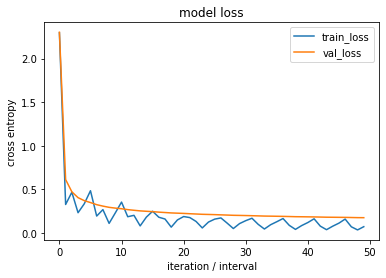

< Metrics >
Accuracy : 0.951


In [29]:
# 初期化 : Xavier, 活性化関数 : Tanh, 最適化 : AdaGrad
print('== Scratch Deep Neural Netrowk ==')
print('< Initializer : Xavier, Activator : Tanh, Optimizer : AdaGrad >')
print('< number of hiddenlayers : 2 ( nodes : 40,20) >\n')
snn_a = ScratchDeepNeuralNetrowkClassifier(n_layers=4, 
                                           n_nodes=[40, 20], 
                                           initializer='Xavier', 
                                           sigma=None, 
                                           activator='tanh', 
                                           optimizer='AdaGrad', 
                                           lr=0.01, 
                                           batch_size=20, 
                                           epoch=10, 
                                           interval=500,
                                           verbose=False)
snn_a.fit(X_train, y_train, X_val, y_val)
# 学習曲線描画
print('< Lerning Curve >')
learning_curve(25000, 500, snn_a.cross_entropys, snn_a.cross_entropys_val)

# Accuracy算出
print('< Metrics >')
y_pred = snn_a.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

== Scratch Deep Neural Netrowk ==
< Initializer : Xavier, Activator : Tanh, Optimizer : Momentum >
< number of hiddenlayers : 2 ( nodes : 40,20) >

< Lerning Curve >


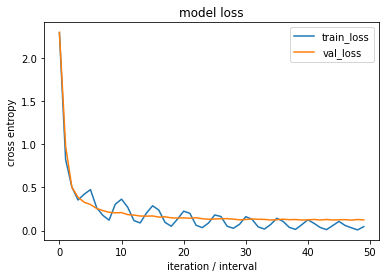

< Metrics >
Accuracy : 0.964


In [30]:
# 初期化 : Xavier, 活性化関数 : Tanh, 最適化 : Momentum
print('== Scratch Deep Neural Netrowk ==')
print('< Initializer : Xavier, Activator : Tanh, Optimizer : Momentum >')
print('< number of hiddenlayers : 2 ( nodes : 40,20) >\n')
snn_m = ScratchDeepNeuralNetrowkClassifier(n_layers=4, 
                                           n_nodes=[40, 20], 
                                           initializer='Xavier', 
                                           sigma=None, 
                                           activator='tanh', 
                                           optimizer='Momentum', 
                                           lr=0.01, 
                                           batch_size=20, 
                                           epoch=10, 
                                           interval=500,
                                           verbose=False)
snn_m.fit(X_train, y_train, X_val, y_val)
# 学習曲線描画
print('< Lerning Curve >')
learning_curve(25000, 500, snn_m.cross_entropys, snn_m.cross_entropys_val)

# Accuracy算出
print('< Metrics >')
y_pred = snn_m.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

== Learning Curves by Optimizers ==
< Initializer : Xavier, Actiator : Tanh >


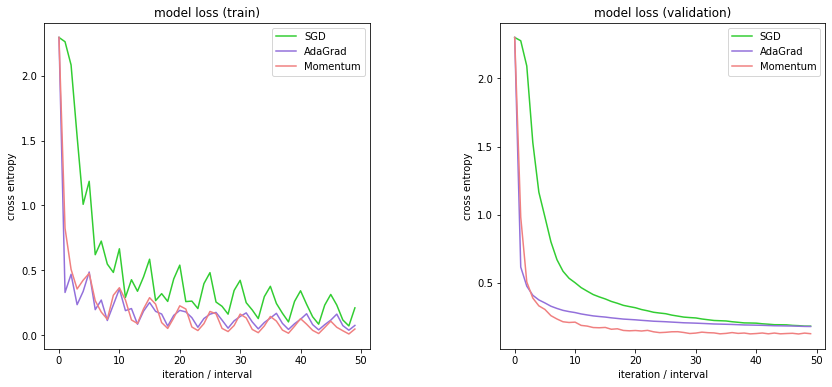

In [31]:
# 手法間でのLearning Curveを比較
print('== Learning Curves by Optimizers ==')
print('< Initializer : Xavier, Actiator : Tanh >')
plt.figure(figsize=(14,6))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

# 訓練データ
plt.subplot(1,2,1)
plt.plot(np.arange(50), snn_x.cross_entropys, label='SGD', color='limegreen')
plt.plot(np.arange(50), snn_a.cross_entropys, label='AdaGrad', color='mediumpurple')
plt.plot(np.arange(50), snn_m.cross_entropys, label='Momentum', color='lightcoral')
plt.title('model loss (train)')
plt.xlabel('iteration / interval')
plt.ylabel('cross entropy')
plt.legend()

# 検証データ
plt.subplot(1,2,2)
plt.plot(np.arange(50), snn_x.cross_entropys_val, label='SGD', color='limegreen')
plt.plot(np.arange(50), snn_a.cross_entropys_val, label='AdaGrad', color='mediumpurple')
plt.plot(np.arange(50), snn_m.cross_entropys_val, label='Momentum', color='lightcoral')
plt.title('model loss (validation)')
plt.xlabel('iteration / interval')
plt.ylabel('cross entropy')
plt.legend()

plt.show()

- SGDは学習の進みが最も遅いが、最終精度はAdaGradと変わらず、さらにepochを重ねるとAdaGradよりも誤差を小さくするかもしれない
- AdaGradは初期の学習は早く進むが、iterationが進むにつれ学習率が落ちていく
- Momentumは勾配方向の力を反映するためか、validationでもiteration毎の変動がある
- 最終性能もMomentumが若干高く、動きにより局所最適解を抜ける効果があるのか

### 4. Xavier, $tanh$ vs He, $ReLU$
　互いの推奨の組み合わせで比較してみる。  
　ReLUの勾配消失回避効果をみるため、隠れ層を 5 層に増やす  
　学習率 0.01 では学習できなかったため、0.1 に上げている

== Scratch Deep Neural Netrowk ==
< Initializer : Xavier, Activator : Tanh, Optimizer : SGD >
< number of hiddenlayers : 7 ( nodes : 40,40,40,40,40) >

< Lerning Curve >


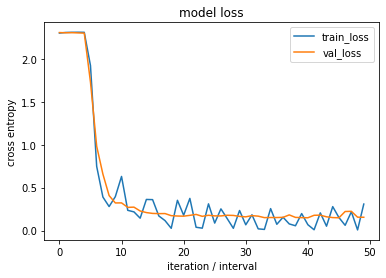

< Metrics >
Accuracy : 0.960


In [32]:
# 初期化 : Xavier, 活性化関数 : Tanh, 最適化 : SGD
print('== Scratch Deep Neural Netrowk ==')
print('< Initializer : Xavier, Activator : Tanh, Optimizer : SGD >')
print('< number of hiddenlayers : 7 ( nodes : 40,40,40,40,40) >\n')
snn_xt = ScratchDeepNeuralNetrowkClassifier(n_layers=7, 
                                           n_nodes=[40, 40, 40, 40, 40], 
                                           initializer='Xavier', 
                                           sigma=None, 
                                           activator='tanh', 
                                           optimizer='SGD', 
                                           lr=0.1, 
                                           batch_size=20, 
                                           epoch=10, 
                                           interval=500,
                                           verbose=False)
snn_xt.fit(X_train, y_train, X_val, y_val)
# 学習曲線描画
print('< Lerning Curve >')
learning_curve(25000, 500, snn_xt.cross_entropys, snn_xt.cross_entropys_val)

# Accuracy算出
print('< Metrics >')
y_pred = snn_xt.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

== Scratch Deep Neural Netrowk ==
< Initializer : He, Activator : ReLU, Optimizer : SGD >
< number of hiddenlayers : 7 ( nodes : 40,40,40,40,40) >

< Lerning Curve >


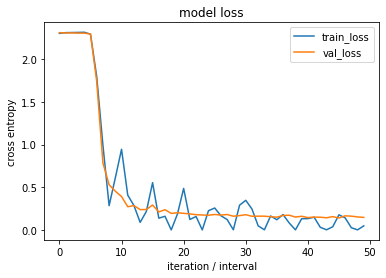

< Metrics >
Accuracy : 0.961


In [37]:
# 初期化 : He, 活性化関数 : ReLU, 最適化 : SGD
print('== Scratch Deep Neural Netrowk ==')
print('< Initializer : He, Activator : ReLU, Optimizer : SGD >')
print('< number of hiddenlayers : 7 ( nodes : 40,40,40,40,40) >\n')
snn_hr = ScratchDeepNeuralNetrowkClassifier(n_layers=7, 
                                            n_nodes=[40, 40, 40, 40, 40], 
                                            initializer='He', 
                                            sigma=None, 
                                            activator='ReLU', 
                                            optimizer='SGD', 
                                            lr=0.1, 
                                            batch_size=20, 
                                            epoch=10, 
                                            interval=500,
                                            verbose=False)
snn_hr.fit(X_train, y_train, X_val, y_val)
# 学習曲線描画
print('< Lerning Curve >')
learning_curve(25000, 500, snn_hr.cross_entropys, snn_hr.cross_entropys_val)

# Accuracy算出
print('< Metrics >')
y_pred = snn_hr.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

== Learning Curves ==
< Xavier, tanh vs He, ReLU >


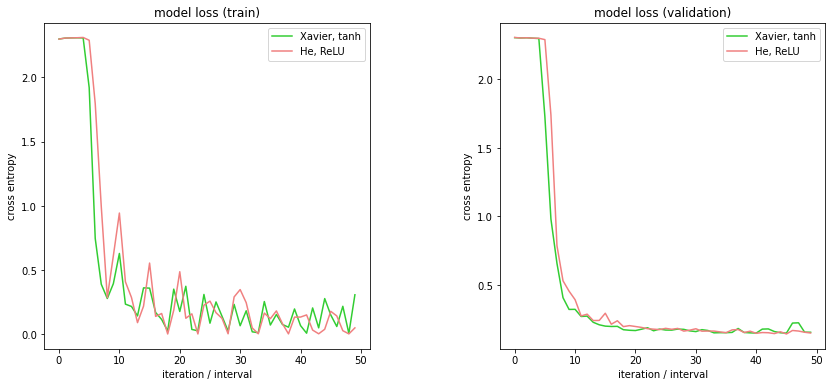

In [38]:
# 手法間でのLearning Curveを比較
print('== Learning Curves ==')
print('< Xavier, tanh vs He, ReLU >')
plt.figure(figsize=(14,6))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

# 訓練データ
plt.subplot(1,2,1)
plt.plot(np.arange(50), snn_xt.cross_entropys, label='Xavier, tanh', color='limegreen')
plt.plot(np.arange(50), snn_hr.cross_entropys, label='He, ReLU', color='lightcoral')
plt.title('model loss (train)')
plt.xlabel('iteration / interval')
plt.ylabel('cross entropy')
plt.legend()

# 検証データ
plt.subplot(1,2,2)
plt.plot(np.arange(50), snn_xt.cross_entropys_val, label='Xavier, tanh', color='limegreen')
plt.plot(np.arange(50), snn_hr.cross_entropys_val, label='He, ReLU', color='lightcoral')
plt.title('model loss (validation)')
plt.xlabel('iteration / interval')
plt.ylabel('cross entropy')
plt.legend()

plt.show()

- 層が深くなれば勾配消失回避効果のある$ReLU$の方がよく学習できると予想されたが、今回の条件では両者にほとんど違いはない
- より層が深くなれば、違いが出てくるだろうか

### 5. Layers  
　Layerの数を増やしてみる。  
　層が深くなるため勾配消失回避として$ReLU$を使用、それに合わせてHeで初期化する。  
　先ほどと同様に、学習率は 0.1 に上げている。

== Scratch Deep Neural Netrowk ==
< Initializer : He, Activator : ReLU, Optimizer : SGD >
< Number of hiddenlayers : 5 ( nodes : 320,160,80,40,20) >

< Lerning Curve >


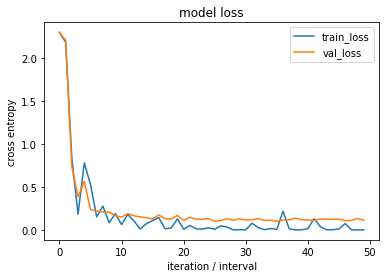

< Metrics >
Accuracy : 0.977


In [39]:
# 隠れ層 : 5層（320, 160, 80, 40, 20）
# 初期化 : He, 活性化関数 : ReLU, 最適化 : SGD
print('== Scratch Deep Neural Netrowk ==')
print('< Initializer : He, Activator : ReLU, Optimizer : SGD >')
print('< Number of hiddenlayers : 5 ( nodes : 320,160,80,40,20) >\n')
snn_n1 = ScratchDeepNeuralNetrowkClassifier(n_layers=7, 
                                            n_nodes=[320, 160, 80, 40, 20], 
                                            initializer='He', 
                                            sigma=None, 
                                            activator='ReLU', 
                                            optimizer='SGD', 
                                            lr=0.1, 
                                            batch_size=20, 
                                            epoch=10, 
                                            interval=500,
                                            verbose=False)
snn_n1.fit(X_train, y_train, X_val, y_val)
# 学習曲線描画
print('< Lerning Curve >')
learning_curve(25000, 500, snn_n1.cross_entropys, snn_n1.cross_entropys_val)

# Accuracy算出
print('< Metrics >')
y_pred = snn_n1.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

== Scratch Deep Neural Netrowk ==
< Initializer : He, Activator : ReLU, Optimizer : SGD >
< Number of hiddenlayers : 5 ( nodes : 80,80,80,80,80) >

< Lerning Curve >


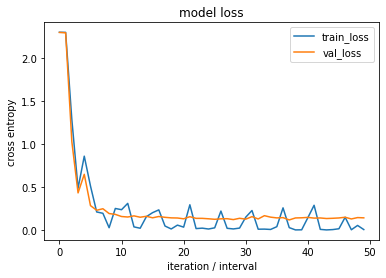

< Metrics >
Accuracy : 0.965


In [40]:
# 隠れ層 : 5層（80, 80, 80, 80, 80）
# 初期化 : He, 活性化関数 : ReLU, 最適化 : SGD
print('== Scratch Deep Neural Netrowk ==')
print('< Initializer : He, Activator : ReLU, Optimizer : SGD >')
print('< Number of hiddenlayers : 5 ( nodes : 80,80,80,80,80) >\n')
snn_n2 = ScratchDeepNeuralNetrowkClassifier(n_layers=7, 
                                            n_nodes=[80, 80, 80, 80, 80], 
                                            initializer='He', 
                                            sigma=None, 
                                            activator='ReLU', 
                                            optimizer='SGD', 
                                            lr=0.1, 
                                            batch_size=20, 
                                            epoch=10, 
                                            interval=500,
                                            verbose=False)
snn_n2.fit(X_train, y_train, X_val, y_val)
# 学習曲線描画
print('< Lerning Curve >')
learning_curve(25000, 500, snn_n2.cross_entropys, snn_n2.cross_entropys_val)

# Accuracy算出
print('< Metrics >')
y_pred = snn_n2.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

== Learning Curves by Layers & Nodes==
< 320,160,80,40,20 vs 80,80,80,80,80 >


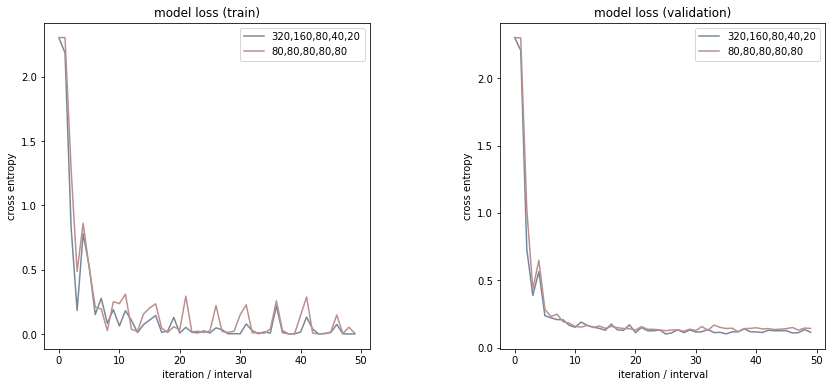

In [41]:
# 手法間でのLearning Curveを比較
print('== Learning Curves by Layers & Nodes==')
print('< 320,160,80,40,20 vs 80,80,80,80,80 >')
plt.figure(figsize=(14,6))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

# 訓練データ
plt.subplot(1,2,1)
plt.plot(np.arange(50), snn_n1.cross_entropys, label='320,160,80,40,20', color='lightslategrey')
plt.plot(np.arange(50), snn_n2.cross_entropys, label='80,80,80,80,80', color='rosybrown')
plt.title('model loss (train)')
plt.xlabel('iteration / interval')
plt.ylabel('cross entropy')
plt.legend()

# 検証データ
plt.subplot(1,2,2)
plt.plot(np.arange(50), snn_n1.cross_entropys_val, label='320,160,80,40,20', color='lightslategrey')
plt.plot(np.arange(50), snn_n2.cross_entropys_val, label='80,80,80,80,80', color='rosybrown')
plt.title('model loss (validation)')
plt.xlabel('iteration / interval')
plt.ylabel('cross entropy')
plt.legend()

plt.show()

- 学習曲線および評価指標上では、両者の違いはほとんど見られない
- 同条件で隠れ層が2層のモデルはACCが0.95以下だったので、層を増やしたことにより少し性能が上がったようだ
- PCの処理時間はノード数が全て 80 のモデルの方が格段に速く、一層あたりのNode数を大きくし過ぎないほうが良いようだ

### 6. Nodes  
　Nodeの数を増やしてみる。  
　上で学習したモデルに合わせ、Xavier, $tanh$ の組み合わせで比較する。  
　学習率は上記と揃えるため 0.01 とした。

== Scratch Deep Neural Netrowk ==
< Initializer : Xavier, Activator : Tanh, Optimizer : SGD >
< number of hiddenlayers : 2 ( nodes : 400,200) >

< Lerning Curve >


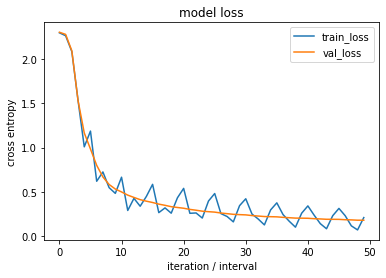

< Metrics >
Accuracy : 0.949


In [42]:
# 初期化 : Xavier, 活性化関数 : Tanh, 最適化 : SGD
print('== Scratch Deep Neural Netrowk ==')
print('< Initializer : Xavier, Activator : Tanh, Optimizer : SGD >')
print('< number of hiddenlayers : 2 ( nodes : 400,200) >\n')
snn_x_10 = ScratchDeepNeuralNetrowkClassifier(n_layers=4, 
                                           n_nodes=[400, 200], 
                                           initializer='Xavier', 
                                           sigma=None, 
                                           activator='tanh', 
                                           optimizer='SGD', 
                                           lr=0.01, 
                                           batch_size=20, 
                                           epoch=10, 
                                           interval=500,
                                           verbose=False)
snn_x_10.fit(X_train, y_train, X_val, y_val)
# 学習曲線描画
print('< Lerning Curve >')
learning_curve(25000, 500, snn_x.cross_entropys, snn_x.cross_entropys_val)

# Accuracy算出
print('< Metrics >')
y_pred = snn_x_10.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

== Learning Curves by Layers & Nodes==
< 40, 20 vs 400, 200 >


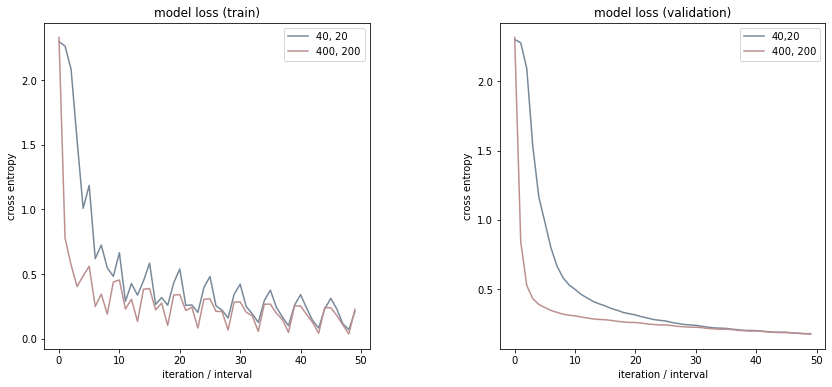

In [43]:
# 手法間でのLearning Curveを比較
print('== Learning Curves by Layers & Nodes==')
print('< 40, 20 vs 400, 200 >')
plt.figure(figsize=(14,6))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

# 訓練データ
plt.subplot(1,2,1)
plt.plot(np.arange(50), snn_x.cross_entropys, label='40, 20', color='lightslategrey')
plt.plot(np.arange(50), snn_x_10.cross_entropys, label='400, 200', color='rosybrown')
plt.title('model loss (train)')
plt.xlabel('iteration / interval')
plt.ylabel('cross entropy')
plt.legend()

# 検証データ
plt.subplot(1,2,2)
plt.plot(np.arange(50), snn_x.cross_entropys_val, label='40,20', color='lightslategrey')
plt.plot(np.arange(50), snn_x_10.cross_entropys_val, label='400, 200', color='rosybrown')
plt.title('model loss (validation)')
plt.xlabel('iteration / interval')
plt.ylabel('cross entropy')
plt.legend()

plt.show()

- 学習はnode数が多い方が早く進んだが、最終的な性能は ACC=0.949 で両者に違いはなかった。
- やはりPCの処理時間は、一層あたりのNode数が増えると長くなる。
- Layer, Node 数は処理能力との兼ね合いもあり、都度試行錯誤するしかなさそうだ